In [1]:
# Importing all Necessary Libraries in a Single Cell to make it Easier
import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.autograd as grad
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from torch.utils.data import Dataset 

In [2]:
# Downloading Fashion MNIST Training Dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # Dataset Location
    train = True, # Fetching Training Dataset 
    download = True, # Downloading
    transform = transforms.Compose([
        transforms.ToTensor() # Converting it into an Tensor 
        ])
)

In [3]:
# Custom Dataset Class for Generating Random Numbers and its Labels 
class CustomDataset(Dataset):
  def __init__(self, train_set, dataset_size):
    random_number = torch.randint(0, 10, (dataset_size, 1)).squeeze() # Generating Random Numbers in range 0 - 9 as 1D Tensor(Batch Size)
    random_one_hot = F.one_hot(random_number, num_classes = 10) # Converting Random Numbers into 10 Digits using One Hot Encoding
    labels = train_set.targets + random_number # Creating Labels for Random Number Data by adding with the Labels of MNIST Dataset 
    self.data = [(train_set[index], (random_one_hot[index], labels[index].item())) for index in range(dataset_size)] 
    # self.data is a list which has MNIST Data along with Labels and Random Number Data along with its Labels
  def __getitem__(self, index):
    data = self.data[index]
    return data
  def __len__(self):
    return len(self.data)

In [4]:
train_dataset = CustomDataset(train_set, len(train_set.targets)) # Creating Custom Training Dataset

In [5]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, # Custom Training Dataset
    batch_size = 64, # Batch Size = 64 (should be in power of 2 to Utilize GPU Better)
    shuffle = True 
    )

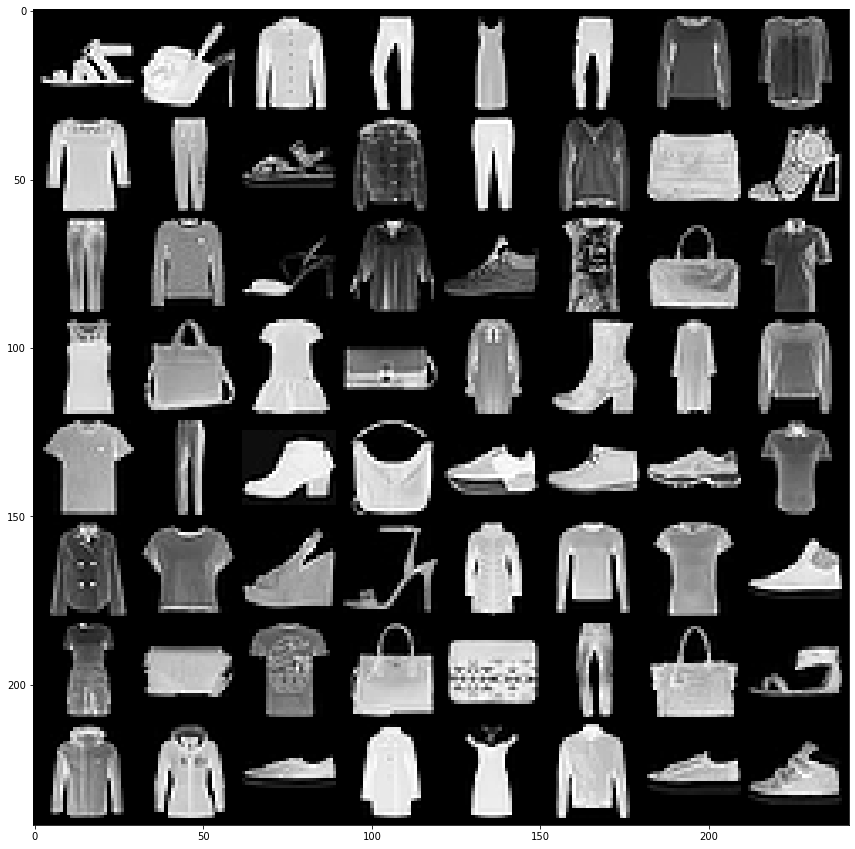

In [6]:
# Plotting a Batch of Images from the Dataset in order to make Inference 
batch = next(iter(data_loader)) # getting an Batch of 100 Images from Total Dataset of 60000 Images
data1, data2 = batch # Unpacking Fashion MNIST Data and Random Number Data
images, labels1 = data1 # Unpacking Images and Labels of Fahsion MNIST Dataset
grid = torchvision.utils.make_grid(images, nrow = 8) # Creating Grid 
plt.figure(figsize = (15, 15)) # Defining Output Figure Size
plt.imshow(np.transpose(grid, (1, 2, 0))) # Displaying 

In [7]:
# Building a Neural Network 1 which takes two inputs(image and random number) then mixes the Convoluted Output of an Image and Random Number at Fully Connected Layer to produces two Outputs.
class Network1(nn.Module):
  def __init__(self, output_class):
    super().__init__()
    self.output_class = output_class 
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3)# input = 28*28, output = 26*26, RF = 3, kernel_size = 3*3
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)# input = 26*26, output = 24*24, RF = 5, kernel_size = 3*3
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)# input = 24*24, output = 22*22, RF = 7, kernel_size = 3*3
    self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)# input = 22*22, output = 20*20, RF = 9, kernel_size = 3*3
    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)# input = 20*20, output = 18*18, RF = 11, kernel_size = 3*3
    # Max Pooling Layer - input 18*18, kernel_size = 2*2, stride = 2, output = 9*9
    self.fc1 = nn.Linear(in_features = 128*9*9+10, out_features = 120) # input = 128*9*9+10(No of channels-128, Image Size-9*9, Random Number-10), output = 120
    self.fc2 = nn.Linear(in_features = 120, out_features = 60) # input = 120, output = 60
    self.output = nn.Linear(in_features = 60, out_features = self.output_class) # input = 60, output = 29
  def forward(self, tensor, random_num):
    # Input Layer
    x = tensor
    # Convolution Layer 1
    x = self.conv1(x)
    x = F.relu(x)
    # Convolution Layer 2 
    x = self.conv2(x)
    x = F.relu(x)
    # Convolution Layer 3
    x = self.conv3(x)
    x = F.relu(x)
    # Convolution Layer 4 
    x = self.conv4(x)
    x = F.relu(x)
    # Convolution Layer 5 
    x = self.conv5(x)
    x = F.relu(x)
    # Max Pooling 
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    # Flattening Our Tensor and adding the one hot encoded value of the Random Number. 
    x = x.reshape(x.shape[0], -1) # Flattening of Tensor
    x = torch.cat((x, random_num), dim = 1)
    # x = torch.cat((x, F.one_hot(random_num, num_classes=10)), dim = 1) # num_classes = 10 (0 - 9) Possible Values.
    # Fully Connected Layer 1 
    x = self.fc1(x)
    x = F.relu(x)
    # Fully Connected Layer 2
    x = self.fc2(x)
    x = F.relu(x)
    # Output Layer
    x = self.output(x)
    x = F.softmax(x, dim = 1)

    return x[:,:10], x[:,10:]
# Number of Output class is equal to sum of unique classes of the dataset and the 19 possible values for the second output
output_class = torch.unique(train_set.targets).shape[0] + 19 # 19 indicates the possible values for sum of prediction and the random number[0 - 18]
network1 = Network1(output_class)

In [8]:
print(network1) # Verifying the Network

Network1(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=10378, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (output): Linear(in_features=60, out_features=29, bias=True)
)


In [9]:
# Function to get Number of Correct Predictions from two outputs and 2 labels
def get_correct_predictions(prediction1, prediction2, labels1, labels2): 
  pred1_correct = prediction1.argmax(dim = 1).eq(labels1) # Compares Prediction1 with labels1 and return true or false
  pred2_correct = prediction2.argmax(dim = 1).eq(labels2) # Compares Prediction2 with labels2 and return true or false
  # Now we need to multiply prediction1 with prediction2 to get Correct Predictions in both the cases and then sum them up. 
  pred_correct = (pred1_correct * pred2_correct).sum().item() 
  return pred_correct # Returning the Total Number of Correct Predictions

In [10]:
# Function to Train the Network with all the Images in the Dataset and Running it for 10 Epochs to Improve the Accuracy.
def model_training(dataset, epoch_no, network): 
  optimizer = optim.Adam(params = network.parameters(), lr = 0.001) # Defining Optimizer for the Neural Network (Adam in this case)
  for epoch in range(1, epoch_no + 1): # Outer for loop to train the Network with Multiple Epochs
    total_loss = 0 # Variable to Gauge Loss for the Respective Epoch
    total_correct = 0 # Variable to keep track of Total Number of Correct Predictions
    image_count = 0 # Variable to keep track of Images count 
    for batch_no, batch in enumerate(dataset, start = 1): # Inner for loop to train the network with batch of Images
      data1, data2 = batch # Unpacking Fashion MNIST Data and Random Number Data
      images, labels1 = data1 # Unpacking Images and Labels of Fashion MNIST Dataset
      random_number, labels2 = data2 # Unpacking Random Number Data and it Labels
      prediction1, prediction2 = network(images, random_number) # Passing the batch of Images, Random Values to the Network 
      optimizer.zero_grad() # Making the Gradients Zero to Release the Gradients of Previous batch
      loss = F.cross_entropy(prediction1, labels1) + F.cross_entropy(prediction2, labels2) # Summing the Loss for both the Outputs.
      total_loss += loss.item() # Adding it to the Total Loss for the Current Epoch
      total_correct += get_correct_predictions(prediction1, prediction2, labels1, labels2) # Total Correct
      loss.backward() # Calculating the Gradients
      optimizer.step() # Updating the Weights of the Network
      image_count += images.shape[0]
    if epoch_no <= 20:
      print(f'Epoch {epoch} Result :-')
      print(f'Total Images Processed in this Epoch : {image_count}')
      print(f'Loss for this Current Epoch : {total_loss}')
      print(f'Total Number of Correct Predictions for both the Outputs : {total_correct}')
    elif epoch_no > 20 and epoch%10 == 0:
      print(f'Epoch {epoch} Result :-')
      print(f'Total Images Processed in this Epoch : {image_count}')
      print(f'Loss for this Current Epoch : {total_loss}')
      print(f'Total Number of Correct Predictions for both the Outputs : {total_correct}')
  print(f'Model Training Completed!!!!')

In [11]:
model_training(data_loader, 10, network1) # Calling the model_training Function and passing network1 

Epoch 1 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4712.565270423889
Total Number of Correct Predictions for both the Outputs : 1754
Epoch 2 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4563.3097314834595
Total Number of Correct Predictions for both the Outputs : 2898
Epoch 3 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4549.97397851944
Total Number of Correct Predictions for both the Outputs : 3053
Epoch 4 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4543.652658462524
Total Number of Correct Predictions for both the Outputs : 3129
Epoch 5 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4541.537298679352
Total Number of Correct Predictions for both the Outputs : 2818
Epoch 6 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4538.679551124573
Total Number o

In [12]:
# Building a Neural Network 2 which takes one input and produces two outputs 
class Network2(nn.Module):
  def __init__(self, output_class):
    super().__init__()
    self.output_class = output_class 
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3)# input = 28*28, output = 26*26, RF = 3, kernel_size = 3*3
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)# input = 26*26, output = 24*24, RF = 5, kernel_size = 3*3
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)# input = 24*24, output = 22*22, RF = 7, kernel_size = 3*3
    self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)# input = 22*22, output = 20*20, RF = 9, kernel_size = 3*3
    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)# input = 20*20, output = 18*18, RF = 11, kernel_size = 3*3
    # Max Pooling - input 18*18, kernel_size = 2*2, stride = 2, output = 9*9
    self.fc1 = nn.Linear(in_features = 128*9*9, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 60)
    self.output = nn.Linear(in_features = 60, out_features = self.output_class)
  def forward(self, tensor, random_value):
    # Input Layer
    for index in range(tensor.shape[0]): # for loop to iterate through each image in the Batch
        tensor[index, :, -1, -10:] = random_value[index] # Replacing last ten values of 28*28 Image with this One Hot Encoded Random Values
    x = tensor
    # Convolution Layer 1
    x = self.conv1(x)
    x = F.relu(x)
    # Convolution Layer 2 
    x = self.conv2(x)
    x = F.relu(x)
    # Convolution Layer 3
    x = self.conv3(x)
    x = F.relu(x)
    # Convolution Layer 4 
    x = self.conv4(x)
    x = F.relu(x)
    # Convolution Layer 5 
    x = self.conv5(x)
    x = F.relu(x)
    # Max Pooling 
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    # Flattening Our Tensor
    x = x.reshape(x.shape[0], -1) # Flattening of Tensor
    # Fully Connected Layer 1 
    x = self.fc1(x)
    x = F.relu(x)
    # Fully Connected Layer 2
    x = self.fc2(x)
    x = F.relu(x)
    # Output Layer
    x = self.output(x)
    x = F.softmax(x, dim = 1)

    return x[:,:10], x[:,10:]
# Number of Output class is equal to sum of unique classes of the dataset and the 19 possible values for the second output
output_class = torch.unique(train_set.targets).shape[0] + 19 # 19 indicates the possible values for sum of prediction and the random number[0 - 18]
network2 = Network2(output_class)

In [13]:
print(network2) # Verifying the Network

Network2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (output): Linear(in_features=60, out_features=29, bias=True)
)


In [14]:
model_training(data_loader, 10, network2) # Calling the model_training Function and Passing network2 this time.

Epoch 1 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4918.738207817078
Total Number of Correct Predictions for both the Outputs : 582
Epoch 2 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4918.762380599976
Total Number of Correct Predictions for both the Outputs : 586
Epoch 3 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4918.793630599976
Total Number of Correct Predictions for both the Outputs : 586
Epoch 4 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4918.809255599976
Total Number of Correct Predictions for both the Outputs : 586
Epoch 5 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4918.840513706207
Total Number of Correct Predictions for both the Outputs : 586
Epoch 6 Result :-
Total Images Processed in this Epoch : 60000
Loss for this Current Epoch : 4927.9306745529175
Total Number of Co

In [15]:
 # Downloading Test Dataset to Evaluate the Model
test_set = torchvision.datasets.FashionMNIST(   
    root = './data', # Dataset Location
    train = False, # Fetching Test Dataset
    download = True, # Downloading
    transform = transforms.Compose([
        transforms.ToTensor() # Converting it into an Tensor 
        ])
)
print(f'Test Set of Fashion MNIST Dataset has {len(test_set)} Images and Labels')

Test Set of Fashion MNIST Dataset has 10000 Images and Labels


In [16]:
test_dataset = CustomDataset(test_set, len(test_set.targets)) # Generating Custom Test Dataset 

In [17]:
# Loading Custom Dataset as a Batch 
test_loader = torch.utils.data.DataLoader(
    train_dataset, # Custom Dataset
    batch_size = 100, # Batch Size = 100 (Snce we are not Training the Model with this dataset, the Batch Size can be any value)
    shuffle = True 
    )

In [19]:
# Function to Evaluate the Model. Returns Accuracy of the Model on given Dataset 
def evaluate_model(model, dataset):
  total_correct = 0 # Variable to keep track of Total Number of Correct Predictions
  image_count = 0 # Variable to keep track of Images count 
  for batch_no, batch in enumerate(dataset, start = 1): # Inner for loop to train the network with batch of Images
    data1, data2 = batch # Unpacking Fashion MNIST Data and Random Number Data
    images, labels1 = data1 # Unpacking Images and Labels of Fashion MNIST Dataset
    random_number, labels2 = data2 # Unpacking Random Number Data and its Labels 
    prediction1, prediction2 = model(images, random_number) # Passing the batch of Images, Random Values to the Network 
    total_correct += get_correct_predictions(prediction1, prediction2, labels1, labels2) # Total Correct Predictions
    image_count += images.shape[0] # Incrementing Image Count
  accuracy = (total_correct/image_count) * 100 # Calculates Accuracy by dividing the Number of Correct Predictions with Total Predictions 
  return accuracy 


In [22]:
accuracy_model1 = evaluate_model(network1, test_loader)
print(f'Accuracy of network1 Model Calculated from Test Dataset is found to be {accuracy_model1}%')

Accuracy of network1 Model Calculated from Test Dataset is found to be 2.6149999999999998%


In [23]:
accuracy_model2 = evaluate_model(network2, test_loader)
print(f'Accuracy of network2 Model Calculated from Test Dataset is found to be {accuracy_model2}%')

Accuracy of network2 Model Calculated from Test Dataset is found to be 0.0%
